In [1]:
import networkx as nx
import graphviz
import matplotlib.pylab as plt
import numpy as np

##  Define Graph


In [17]:
N = 8
G = nx.Graph([(n,n+1) for n in range(N)] + [(N,0)])
G.edges()

[(0, 1), (0, 8), (1, 2), (2, 3), (3, 4), (4, 5), (5, 6), (6, 7), (7, 8)]

C:\Users\noam\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
C:\Users\noam\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:138: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  plt.hold(b)
C:\Users\noam\Anaconda3\lib\site-packages\matplotlib\__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
C:\Users\noam\Anaconda3\lib\site-packages\matplotlib\rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0
  warnings.warn("axes.hold is deprecated, will be removed in 3.0

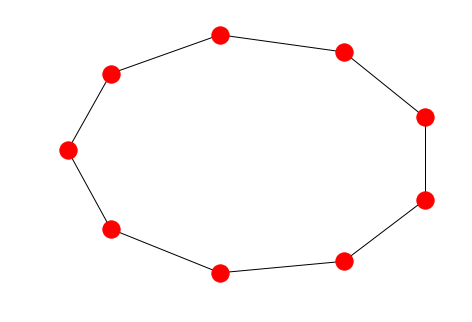

In [20]:
plt.figure()
nx.draw_spectral(G)
plt.show()

In [24]:
L = nx.laplacian_matrix(G)
L.toarray()

array([[ 2, -1,  0,  0,  0,  0,  0,  0, -1],
       [-1,  2, -1,  0,  0,  0,  0,  0,  0],
       [ 0, -1,  2, -1,  0,  0,  0,  0,  0],
       [ 0,  0, -1,  2, -1,  0,  0,  0,  0],
       [ 0,  0,  0, -1,  2, -1,  0,  0,  0],
       [ 0,  0,  0,  0, -1,  2, -1,  0,  0],
       [ 0,  0,  0,  0,  0, -1,  2, -1,  0],
       [ 0,  0,  0,  0,  0,  0, -1,  2, -1],
       [-1,  0,  0,  0,  0,  0,  0, -1,  2]], dtype=int32)

In [31]:
np.linalg.eigh(L.toarray())
# import scipy as sp
# sp.linalg.eigh
# 1/np.sqrt(8)

(array([ -1.22124533e-15,   4.67911114e-01,   4.67911114e-01,
          1.65270364e+00,   1.65270364e+00,   3.00000000e+00,
          3.00000000e+00,   3.87938524e+00,   3.87938524e+00]),
 array([[ -3.33333333e-01,   4.70686258e-01,  -2.60128632e-02,
           1.00195793e-05,   4.71404521e-01,  -1.75997057e-03,
          -4.71401235e-01,  -4.67127247e-01,  -6.33589548e-02],
        [ -3.33333333e-01,   3.77287338e-01,   2.82624285e-01,
          -4.64241087e-01,   8.18684033e-02,  -4.07365460e-01,
           2.37224797e-01,   4.60626066e-01,  -1.00228986e-01],
        [ -3.33333333e-01,   1.07351480e-01,   4.59018390e-01,
          -1.61239257e-01,  -4.42971923e-01,   4.09125431e-01,
           2.34176438e-01,  -3.98566583e-01,   2.51727831e-01],
        [ -3.33333333e-01,  -2.12815328e-01,   4.20632688e-01,
           4.08243281e-01,  -2.35710938e-01,  -1.75997057e-03,
          -4.71401235e-01,   2.88434088e-01,  -3.72864585e-01],
        [ -3.33333333e-01,  -4.33403480e-01,   1.854

In [1]:
! pip install gsp

  Could not find a version that satisfies the requirement gsp (from versions: )
No matching distribution found for gsp
